#### Market Basket Analysis

In [1]:
from platform import python_version
print(python_version())

3.9.13


In [2]:
#!pip install -q efficient_apriori

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from itertools import combinations
import efficient_apriori
from efficient_apriori import apriori

In [4]:
%reload_ext watermark
%watermark --iversions

efficient_apriori: 2.0.3
numpy            : 1.21.5
pandas           : 1.4.4
matplotlib       : 3.5.2



In [5]:
aisles = pd.read_csv('projeto6_analise_de_dados_pyton/dados/aisles.csv')
departments = pd.read_csv('projeto6_analise_de_dados_pyton/dados/departments.csv')
order_products_prior = pd.read_csv('projeto6_analise_de_dados_pyton/dados/order_products__prior.csv')
order_products_train = pd.read_csv('projeto6_analise_de_dados_pyton/dados/order_products__train.csv')
orders = pd.read_csv('projeto6_analise_de_dados_pyton/dados/orders.csv')
products = pd.read_csv('projeto6_analise_de_dados_pyton/dados/products.csv')
sample_submission = pd.read_csv('projeto6_analise_de_dados_pyton/dados/sample_submission.csv')

#### Análise Exploratória

In [6]:
datasets = {'aisles': aisles,
            'departments': departments,
            'order_products_prior': order_products_prior,
            'order_products_train': order_products_train,
            'orders': orders,
            'products': products,
            'sample_submission': sample_submission}

In [7]:
for k, v in datasets.items():
    print(f'Dataset: {k}, Shape: {v.shape}')

Dataset: aisles, Shape: (134, 2)
Dataset: departments, Shape: (21, 2)
Dataset: order_products_prior, Shape: (32434489, 4)
Dataset: order_products_train, Shape: (1384617, 4)
Dataset: orders, Shape: (3421083, 7)
Dataset: products, Shape: (49688, 4)
Dataset: sample_submission, Shape: (75000, 2)


In [8]:
for k, v in datasets.items():
    print(f'Dataset: {k}, Shape: {v.shape}')
    print(f'Dataset: {k}, Columns: {v.columns.tolist()}')

Dataset: aisles, Shape: (134, 2)
Dataset: aisles, Columns: ['aisle_id', 'aisle']
Dataset: departments, Shape: (21, 2)
Dataset: departments, Columns: ['department_id', 'department']
Dataset: order_products_prior, Shape: (32434489, 4)
Dataset: order_products_prior, Columns: ['order_id', 'product_id', 'add_to_cart_order', 'reordered']
Dataset: order_products_train, Shape: (1384617, 4)
Dataset: order_products_train, Columns: ['order_id', 'product_id', 'add_to_cart_order', 'reordered']
Dataset: orders, Shape: (3421083, 7)
Dataset: orders, Columns: ['order_id', 'user_id', 'eval_set', 'order_number', 'order_dow', 'order_hour_of_day', 'days_since_prior_order']
Dataset: products, Shape: (49688, 4)
Dataset: products, Columns: ['product_id', 'product_name', 'aisle_id', 'department_id']
Dataset: sample_submission, Shape: (75000, 2)
Dataset: sample_submission, Columns: ['order_id', 'products']


In [9]:
for k, v in datasets.items():
    print('-'*20)
    print(f'{v.head(3)}\n')

--------------------
   aisle_id                  aisle
0         1  prepared soups salads
1         2      specialty cheeses
2         3    energy granola bars

--------------------
   department_id department
0              1     frozen
1              2      other
2              3     bakery

--------------------
   order_id  product_id  add_to_cart_order  reordered
0         2       33120                  1          1
1         2       28985                  2          1
2         2        9327                  3          0

--------------------
   order_id  product_id  add_to_cart_order  reordered
0         1       49302                  1          1
1         1       11109                  2          1
2         1       10246                  3          0

--------------------
   order_id  user_id eval_set  order_number  order_dow  order_hour_of_day  \
0   2539329        1    prior             1          2                  8   
1   2398795        1    prior             2          

In [10]:
datasets_2 = np.array([['aisles', len(aisles)],
            ['departments', len(departments)],
            ['order_products_prior', len(order_products_prior)],
            ['order_products_train', len(order_products_train)],
            ['orders', len(orders)],
            ['products', len(products)],
            ['sample_submission', len(sample_submission)]])
count_record = pd.DataFrame(datasets_2, columns = ['Arquivo', 'Total de Registros'])
count_record

,Arquivo,Total de Registros
0,aisles,134
1,departments,21
2,order_products_prior,32434489
3,order_products_train,1384617
4,orders,3421083
5,products,49688
6,sample_submission,75000


In [11]:
orders['eval_set'].value_counts()

prior    3214874
train     131209
test       75000
Name: eval_set, dtype: int64

In [12]:
aisles.isna().sum()

aisle_id    0
aisle       0
dtype: int64

In [13]:
for k, v in datasets.items():
    print('-'*20)
    print(f'{v.isna().sum()}')

--------------------
aisle_id    0
aisle       0
dtype: int64
--------------------
department_id    0
department       0
dtype: int64
--------------------
order_id             0
product_id           0
add_to_cart_order    0
reordered            0
dtype: int64
--------------------
order_id             0
product_id           0
add_to_cart_order    0
reordered            0
dtype: int64
--------------------
order_id                       0
user_id                        0
eval_set                       0
order_number                   0
order_dow                      0
order_hour_of_day              0
days_since_prior_order    206209
dtype: int64
--------------------
product_id       0
product_name     0
aisle_id         0
department_id    0
dtype: int64
--------------------
order_id    0
products    0
dtype: int64


#### Feature Extraction

In [14]:
%%time
order_products_prior = order_products_prior.merge(orders, on = 'order_id', how = 'left')
order_products_prior = order_products_prior.merge(products, on = 'product_id', how = 'left')
order_products_prior = order_products_prior.merge(aisles, on = 'aisle_id', how = 'left')
order_products_prior = order_products_prior.merge(departments, on = 'department_id', how = 'left')

Wall time: 28.1 s


In [15]:
order_products_prior.head(5)

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_name,aisle_id,department_id,aisle,department
0,2,33120,1,1,202279,prior,3,5,9,8.0,Organic Egg Whites,86,16,eggs,dairy eggs
1,2,28985,2,1,202279,prior,3,5,9,8.0,Michigan Organic Kale,83,4,fresh vegetables,produce
2,2,9327,3,0,202279,prior,3,5,9,8.0,Garlic Powder,104,13,spices seasonings,pantry
3,2,45918,4,1,202279,prior,3,5,9,8.0,Coconut Butter,19,13,oils vinegars,pantry
4,2,30035,5,0,202279,prior,3,5,9,8.0,Natural Sweetener,17,13,baking ingredients,pantry


In [16]:
order_products_prior.isna().sum()

order_id                        0
product_id                      0
add_to_cart_order               0
reordered                       0
user_id                         0
eval_set                        0
order_number                    0
order_dow                       0
order_hour_of_day               0
days_since_prior_order    2078068
product_name                    0
aisle_id                        0
department_id                   0
aisle                           0
department                      0
dtype: int64

In [17]:
order_products_prior.isnull().sum() / len(order_products_prior) * 100

order_id                  0.00000
product_id                0.00000
add_to_cart_order         0.00000
reordered                 0.00000
user_id                   0.00000
eval_set                  0.00000
order_number              0.00000
order_dow                 0.00000
order_hour_of_day         0.00000
days_since_prior_order    6.40697
product_name              0.00000
aisle_id                  0.00000
department_id             0.00000
aisle                     0.00000
department                0.00000
dtype: float64

In [18]:
%%time
order_products_train = order_products_train.merge(orders, on = 'order_id', how = 'left')
order_products_train = order_products_train.merge(products, on = 'product_id', how = 'left')
order_products_train = order_products_train.merge(aisles, on = 'aisle_id', how = 'left')
order_products_train = order_products_train.merge(departments, on = 'department_id', how = 'left')

Wall time: 2.14 s


In [19]:
order_products_train.head(5)

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_name,aisle_id,department_id,aisle,department
0,1,49302,1,1,112108,train,4,4,10,9.0,Bulgarian Yogurt,120,16,yogurt,dairy eggs
1,1,11109,2,1,112108,train,4,4,10,9.0,Organic 4% Milk Fat Whole Milk Cottage Cheese,108,16,other creams cheeses,dairy eggs
2,1,10246,3,0,112108,train,4,4,10,9.0,Organic Celery Hearts,83,4,fresh vegetables,produce
3,1,49683,4,0,112108,train,4,4,10,9.0,Cucumber Kirby,83,4,fresh vegetables,produce
4,1,43633,5,1,112108,train,4,4,10,9.0,Lightly Smoked Sardines in Olive Oil,95,15,canned meat seafood,canned goods


In [20]:
order_products_train.isna().sum()

order_id                  0
product_id                0
add_to_cart_order         0
reordered                 0
user_id                   0
eval_set                  0
order_number              0
order_dow                 0
order_hour_of_day         0
days_since_prior_order    0
product_name              0
aisle_id                  0
department_id             0
aisle                     0
department                0
dtype: int64

In [21]:
%%time
order_grouped = pd.DataFrame(order_products_prior.groupby('order_id')['product_id'])

Wall time: 1min 28s


In [22]:
order_grouped.shape

(3214874, 2)

In [23]:
order_grouped.head(3)

,0,1
0,2,0 33120 1 28985 2 9327 3 45918 4 ...
1,3,9 33754 10 24838 11 17704 12 2190...
2,4,17 46842 18 26434 19 39758 20 2776...


In [24]:
prod = list()

In [25]:
%%time
for i in range(len(order_grouped[0])):
    prod.append(list(order_grouped.iloc[i][1]))

Wall time: 3min 40s


In [26]:
prod_ = prod

In [27]:
order_ = order_grouped[0]

In [28]:
transactions = pd.DataFrame({'OrderID': order_, 'Products': prod_})

In [29]:
transactions.head(10)

,OrderID,Products
0,2,"[33120, 28985, 9327, 45918, 30035, 17794, 4014..."
1,3,"[33754, 24838, 17704, 21903, 17668, 46667, 174..."
2,4,"[46842, 26434, 39758, 27761, 10054, 21351, 225..."
3,5,"[13176, 15005, 47329, 27966, 23909, 48370, 132..."
4,6,"[40462, 15873, 41897]"
5,7,"[34050, 46802]"
6,8,[23423]
7,9,"[21405, 47890, 11182, 2014, 29193, 34203, 1499..."
8,10,"[24852, 4796, 31717, 47766, 4605, 1529, 21137,..."
9,11,"[30162, 27085, 5994, 1313, 31506]"


#### Análise Estatística Descritiva

##### 1 - Qual o número de pedidos mais frequente entre os usuários?

In [30]:
ord_max_count = orders.groupby('user_id')['order_number'].agg(np.max).reset_index()
ord_max_count.head(3)

,user_id,order_number
0,1,11
1,2,15
2,3,13


In [31]:
ord_max_count = ord_max_count['order_number'].value_counts()
ord_max_count.head(3)

4    23986
5    19590
6    16165
Name: order_number, dtype: int64

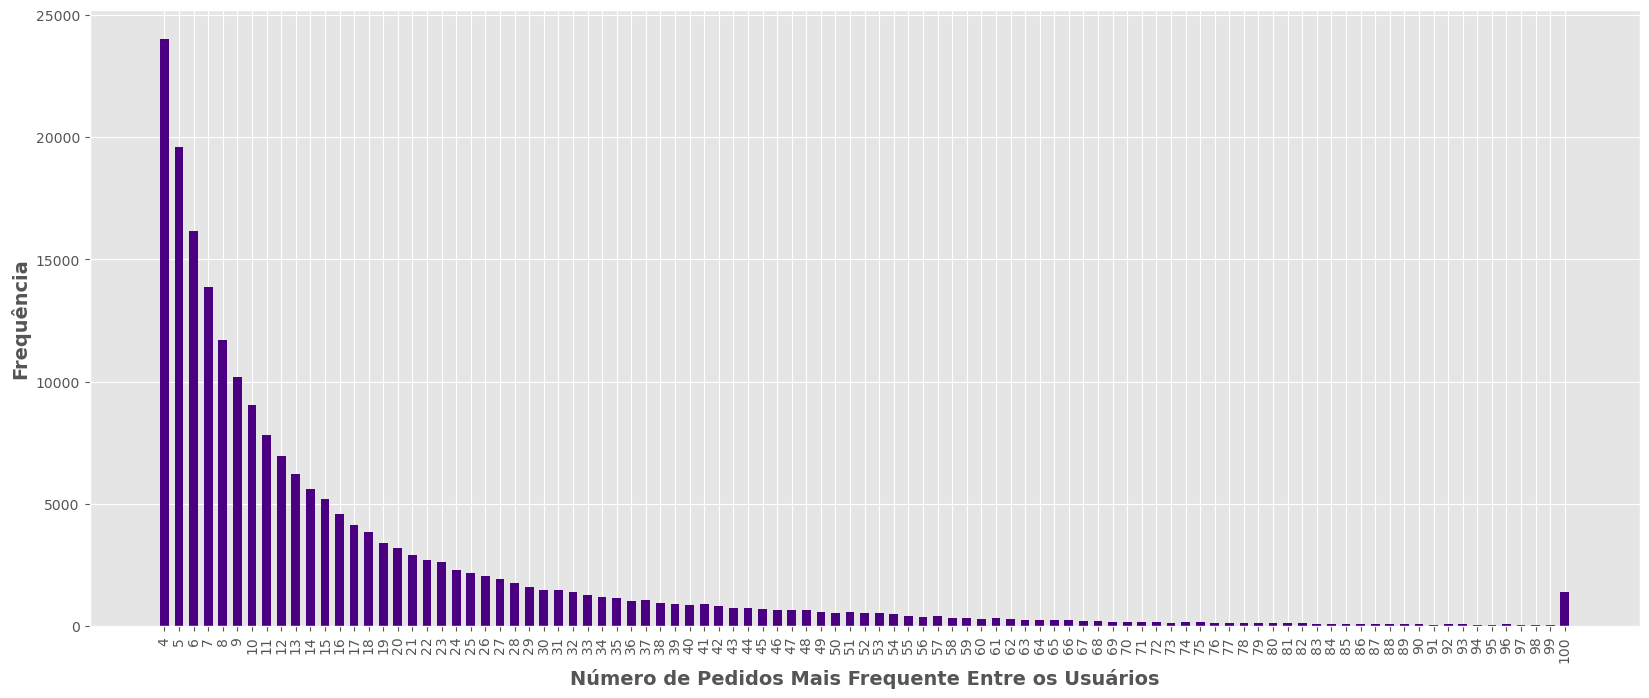

In [32]:
plt.style.use('ggplot')
plt.figure(figsize = (20, 8))
plt.bar(ord_max_count.index, ord_max_count.values, color = 'indigo', width = 0.6)
plt.xticks(ord_max_count.index, rotation = 'vertical')
plt.ylabel('Frequência', fontsize = 14, fontweight = 'bold')
plt.xlabel('Número de Pedidos Mais Frequente Entre os Usuários', fontsize = 14, fontweight = 'bold')
plt.show()

##### 2 - Qual dia da semana tem o maior número de pedidos?

In [33]:
x = [0, 1, 2, 3, 4, 5, 6]
y = [orders[orders['order_dow'] == 0].shape[0],
    orders[orders['order_dow'] == 1].shape[0],
    orders[orders['order_dow'] == 2].shape[0],
    orders[orders['order_dow'] == 3].shape[0],
    orders[orders['order_dow'] == 4].shape[0],
    orders[orders['order_dow'] == 5].shape[0],
    orders[orders['order_dow'] == 6].shape[0]]

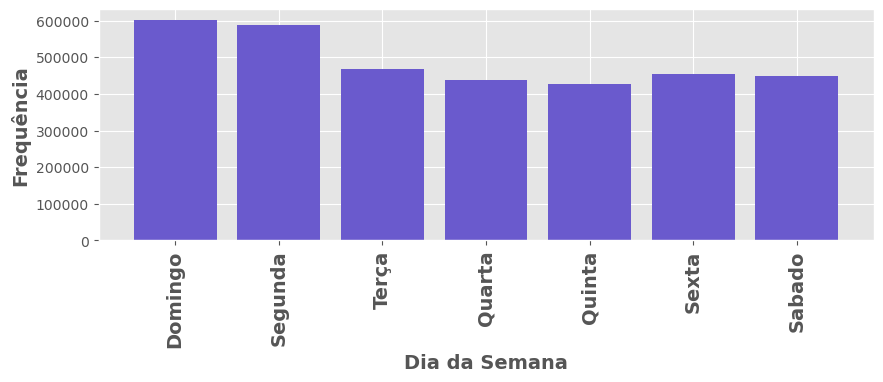

In [34]:
plt.figure(figsize = (10, 3))
plt.bar(x, y, color = 'slateblue')
plt.xlabel('Dia da Semana', fontsize = 14, fontweight = 'bold')
plt.ylabel('Frequência', fontsize = 14, fontweight = 'bold')
plt.xticks(x, ['Domingo', 'Segunda', 'Terça', 'Quarta', 'Quinta', 'Sexta', 'Sabado'],
          size = 14, fontweight = 'bold', rotation = 'vertical')
plt.show()

##### 3 - Qual hora do dia tem o maior número de pedidos?

In [35]:
x = list(range(0,24))
y = list()
for i in range(24):
    y.append(orders[orders['order_hour_of_day'] == i].shape[0])

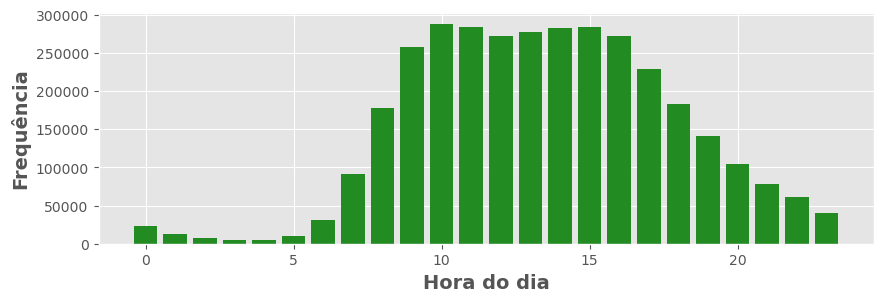

In [36]:
plt.figure(figsize = (10, 3))
plt.bar(x, y, color = 'forestgreen')
plt.xlabel('Hora do dia', fontsize = 14, fontweight = 'bold')
plt.ylabel('Frequência', fontsize = 14, fontweight = 'bold')
plt.show()

##### 4 - Qual departamento tem o maior número de pedidos?

In [37]:
dept_cnt = order_products_prior['department'].value_counts()

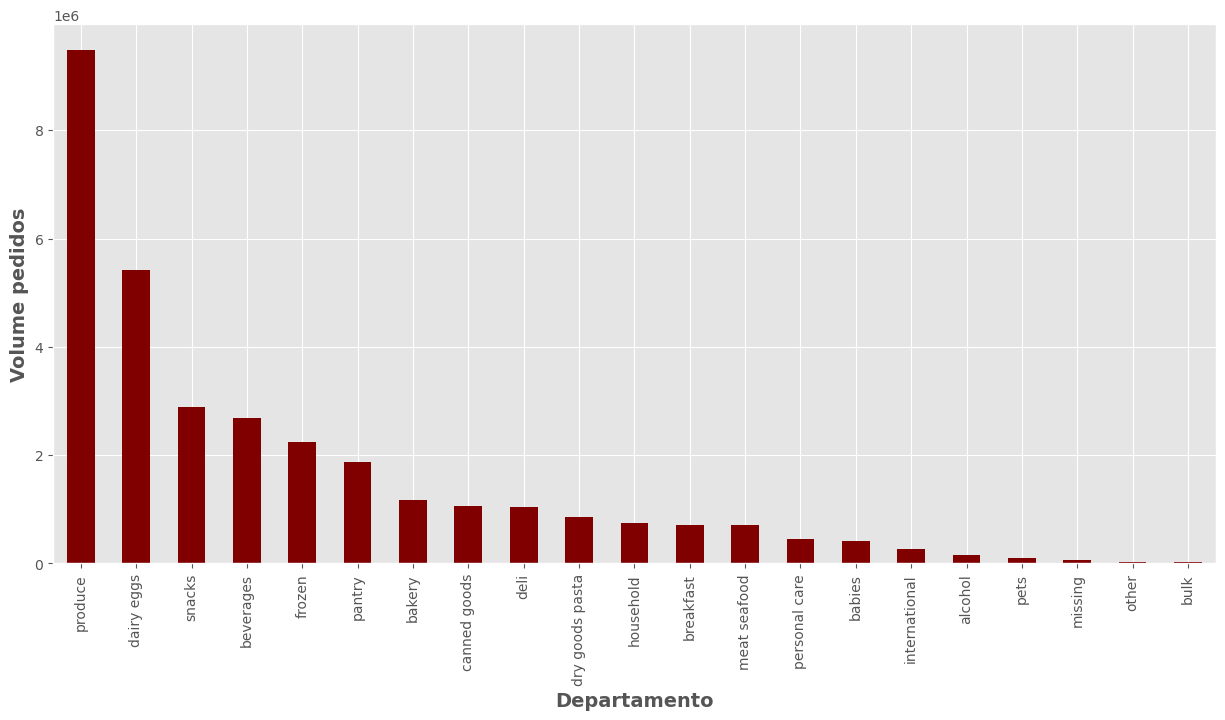

In [38]:
fig = plt.figure(figsize = (15, 7))
dept_cnt.plot(kind = 'bar', color = 'maroon')
plt.xticks(rotation = 90)
plt.xlabel('Departamento', fontsize = 14, fontweight = 'bold')
plt.ylabel('Volume pedidos', fontsize = 14, fontweight = 'bold')
plt.show()

##### 5 - Quais os 20 principais corredores por frequencia de pedidos?

In [39]:
aisle_cnt = order_products_prior['aisle'].value_counts()

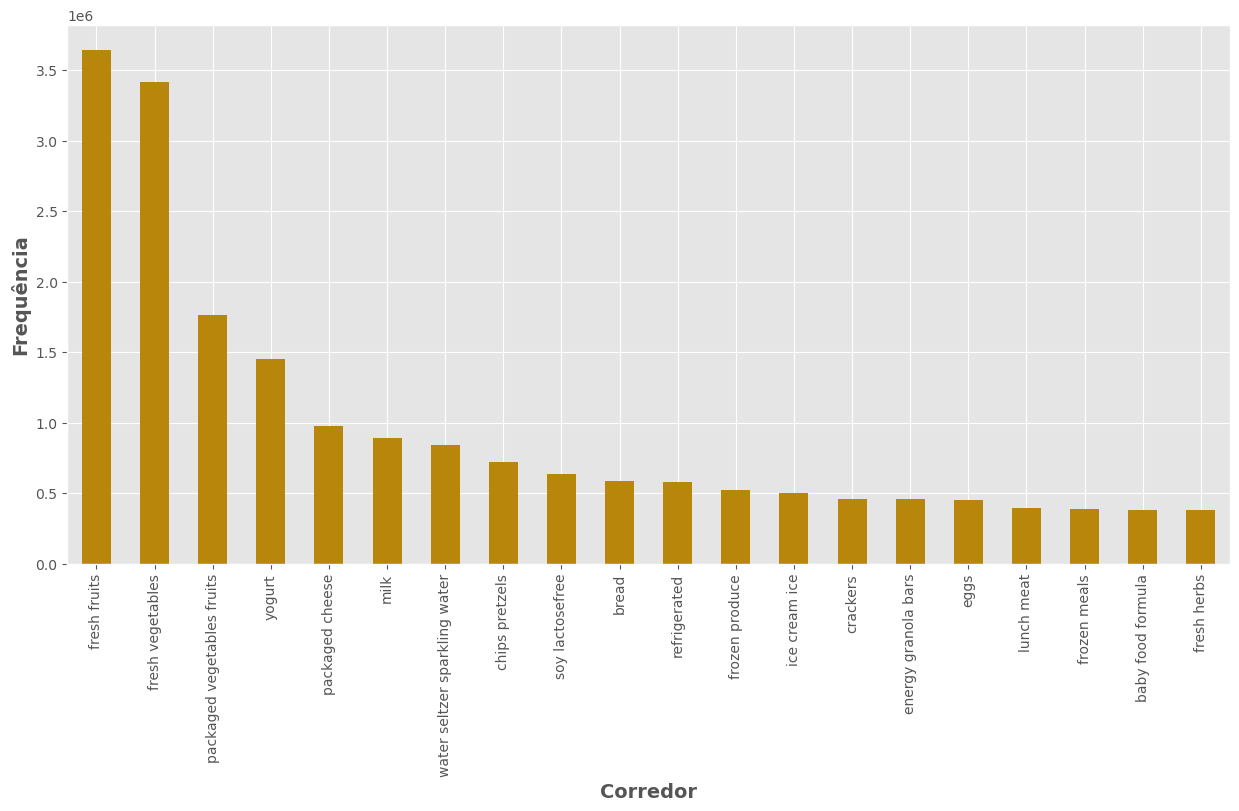

In [40]:
fig = plt.figure(figsize = (15, 7))
aisle_cnt[0:20].plot(kind = 'bar', color = 'darkgoldenrod')
plt.xticks(rotation = 90)
plt.xlabel('Corredor', fontsize = 14, fontweight = 'bold')
plt.ylabel('Frequência', fontsize = 14, fontweight = 'bold')
plt.show()

##### 6 - Quais os 20 principais produtos por frequencia de pedidos?

In [41]:
prod_cnt = order_products_prior['product_name'].value_counts()

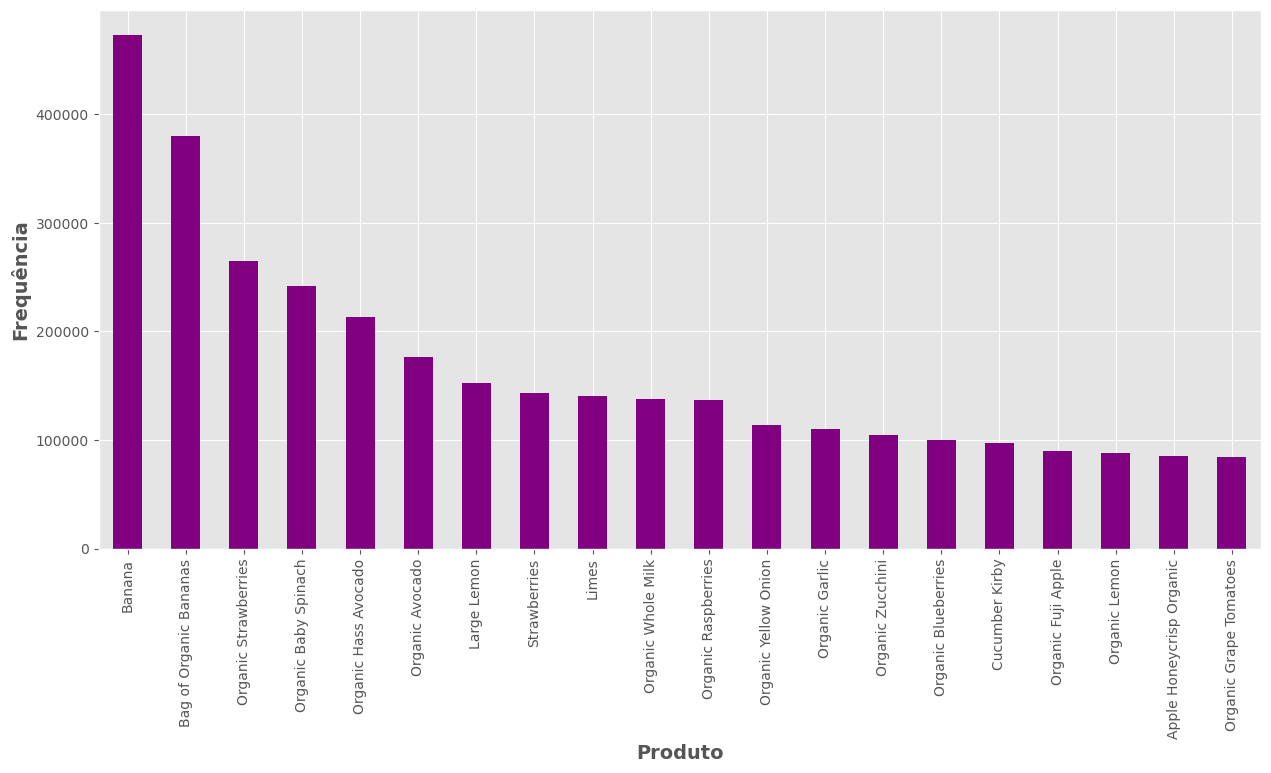

In [42]:
fig = plt.figure(figsize = (15, 7))
prod_cnt[0:20].plot(kind = 'bar', color = 'purple')
plt.xticks(rotation = 90)
plt.xlabel('Produto', fontsize = 14, fontweight = 'bold')
plt.ylabel('Frequência', fontsize = 14, fontweight = 'bold')
plt.show()

##### 7 - Análise de novos pedidos semelhantes a pedidos anteriores (reorder)

In [43]:
%%time
temp_df = order_products_prior.groupby('product_name')['reordered'].agg(['count', 'sum']).rename(
    columns = {'count': 'total', 'sum': 'reorders'})
temp_df = temp_df.sort_values('total', ascending = False).reset_index()

Wall time: 5.25 s


In [44]:
labels = list(temp_df.product_name[0:20])
reorder = list(temp_df.reorders[0:20])
total = list(temp_df.total[0:20])

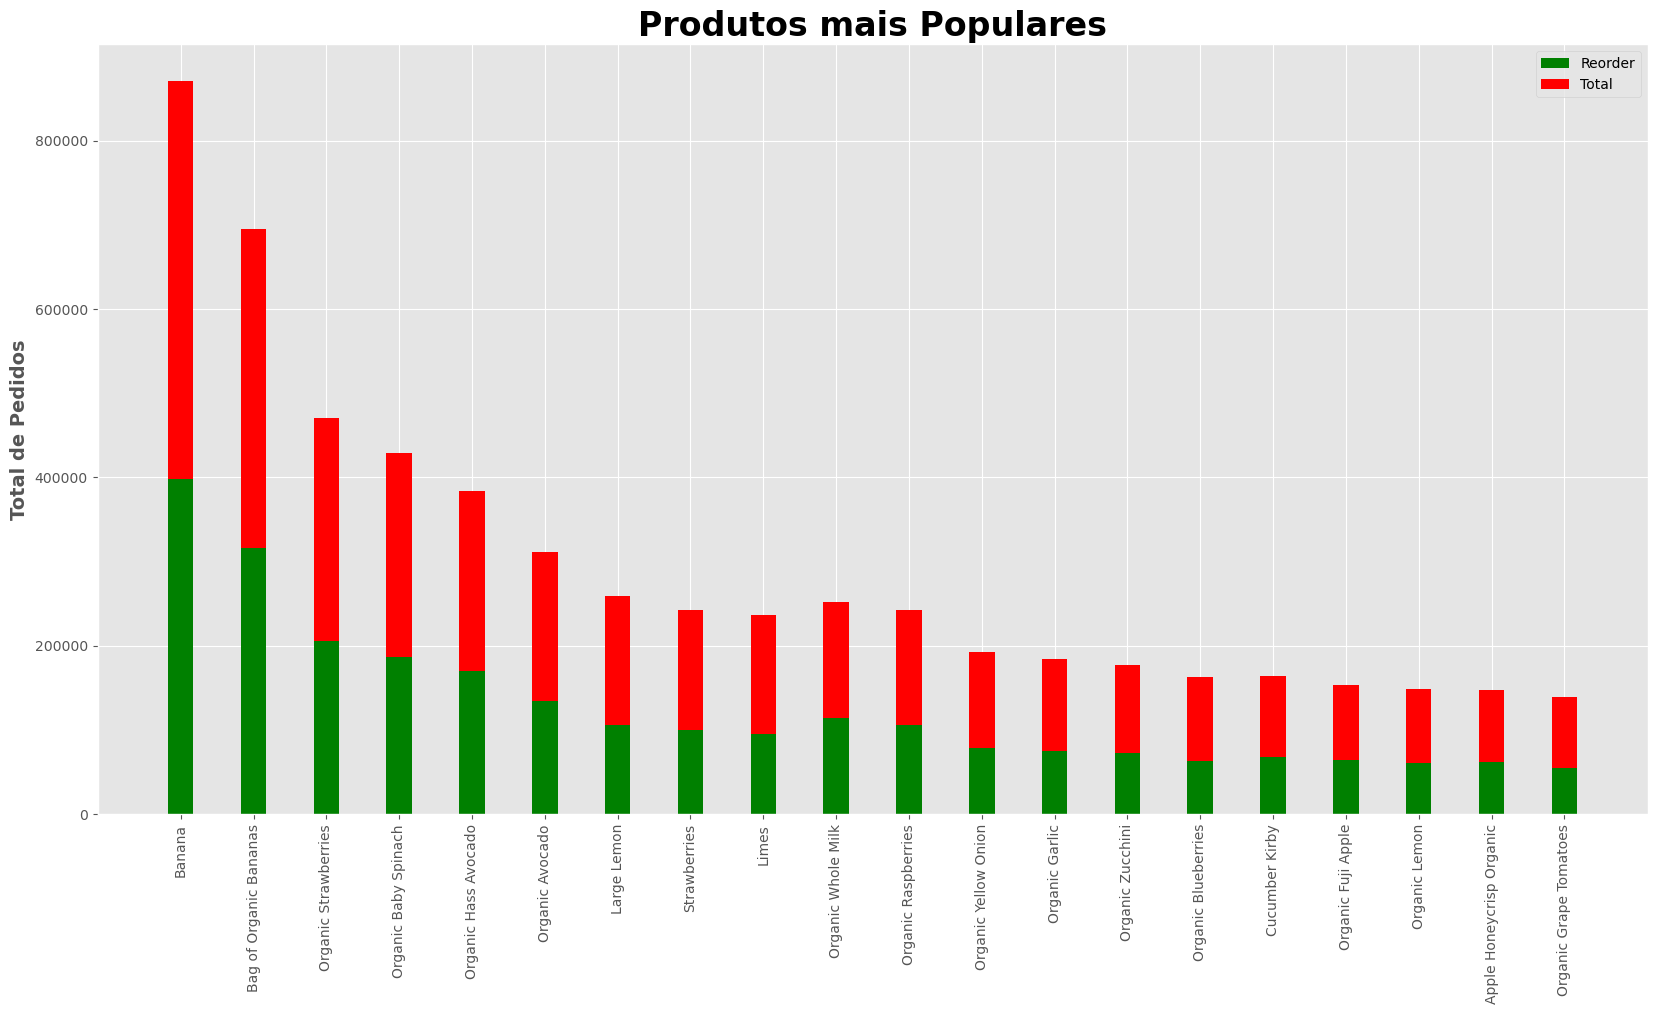

In [45]:
width = 0.35
fig, ax = plt.subplots(figsize = (20, 10))
ax.bar(labels, reorder, width, label = 'Reorder', color = 'green')
ax.bar(labels, total, width, bottom = reorder, label = 'Total', color = 'red')
ax.set_ylabel('Total de Pedidos', fontsize = 14, fontweight = 'bold')
ax.legend()
ax.set_title('Produtos mais Populares',fontsize = 24, fontweight = 'bold')
plt.xticks(rotation = 90)
plt.show()

##### 8 - Análise do reorder por departamento ao longo do tempo

In [46]:
grouped_df = order_products_prior.groupby('department')['reordered'].agg('mean').reset_index()
grouped_df.head(3)

,department,reordered
0,alcohol,0.569924
1,babies,0.578971
2,bakery,0.628141


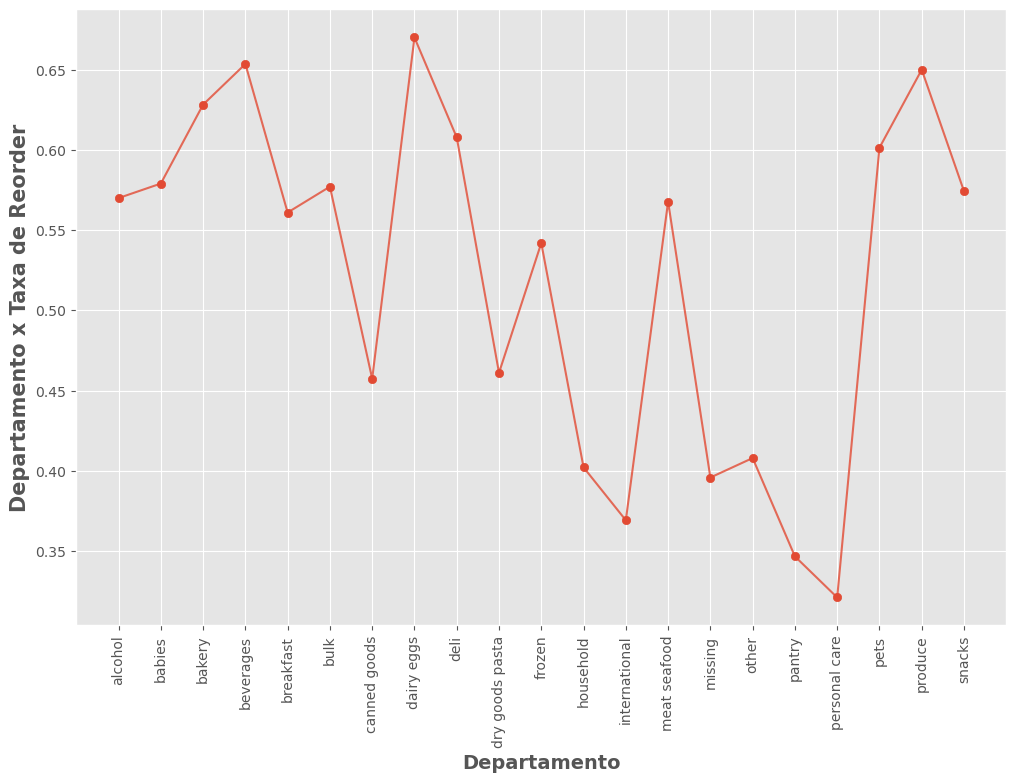

In [47]:
fig = plt.figure(figsize = (12, 8))
plt.plot(list(grouped_df['department']),grouped_df['reordered'].values, alpha=0.8)
plt.scatter(list(grouped_df['department']),grouped_df['reordered'].values)
plt.xticks(rotation = 90)
plt.xlabel('Departamento', fontsize = 14, fontweight = 'bold')
plt.ylabel('Departamento x Taxa de Reorder', fontsize = 15, fontweight = 'bold')
plt.show()

##### 8 - Análise de Reorder e Pedidos

In [48]:
%%time
temp_df = order_products_prior.groupby('department')['reordered'].agg(['count', 'sum']).rename(
    columns = {'count': 'total', 'sum': 'reorders'})
temp_df = temp_df.sort_values('total', ascending = False).reset_index()

Wall time: 2.08 s


In [49]:
temp_df.head(5)

,department,total,reorders
0,produce,9479291,6160710
1,dairy eggs,5414016,3627221
2,snacks,2887550,1657973
3,beverages,2690129,1757892
4,frozen,2236432,1211890


In [50]:
labels = list(temp_df['department'][0:20])
reorder = list(temp_df['reorders'][0:20])
total = list(temp_df['total'][0:20])

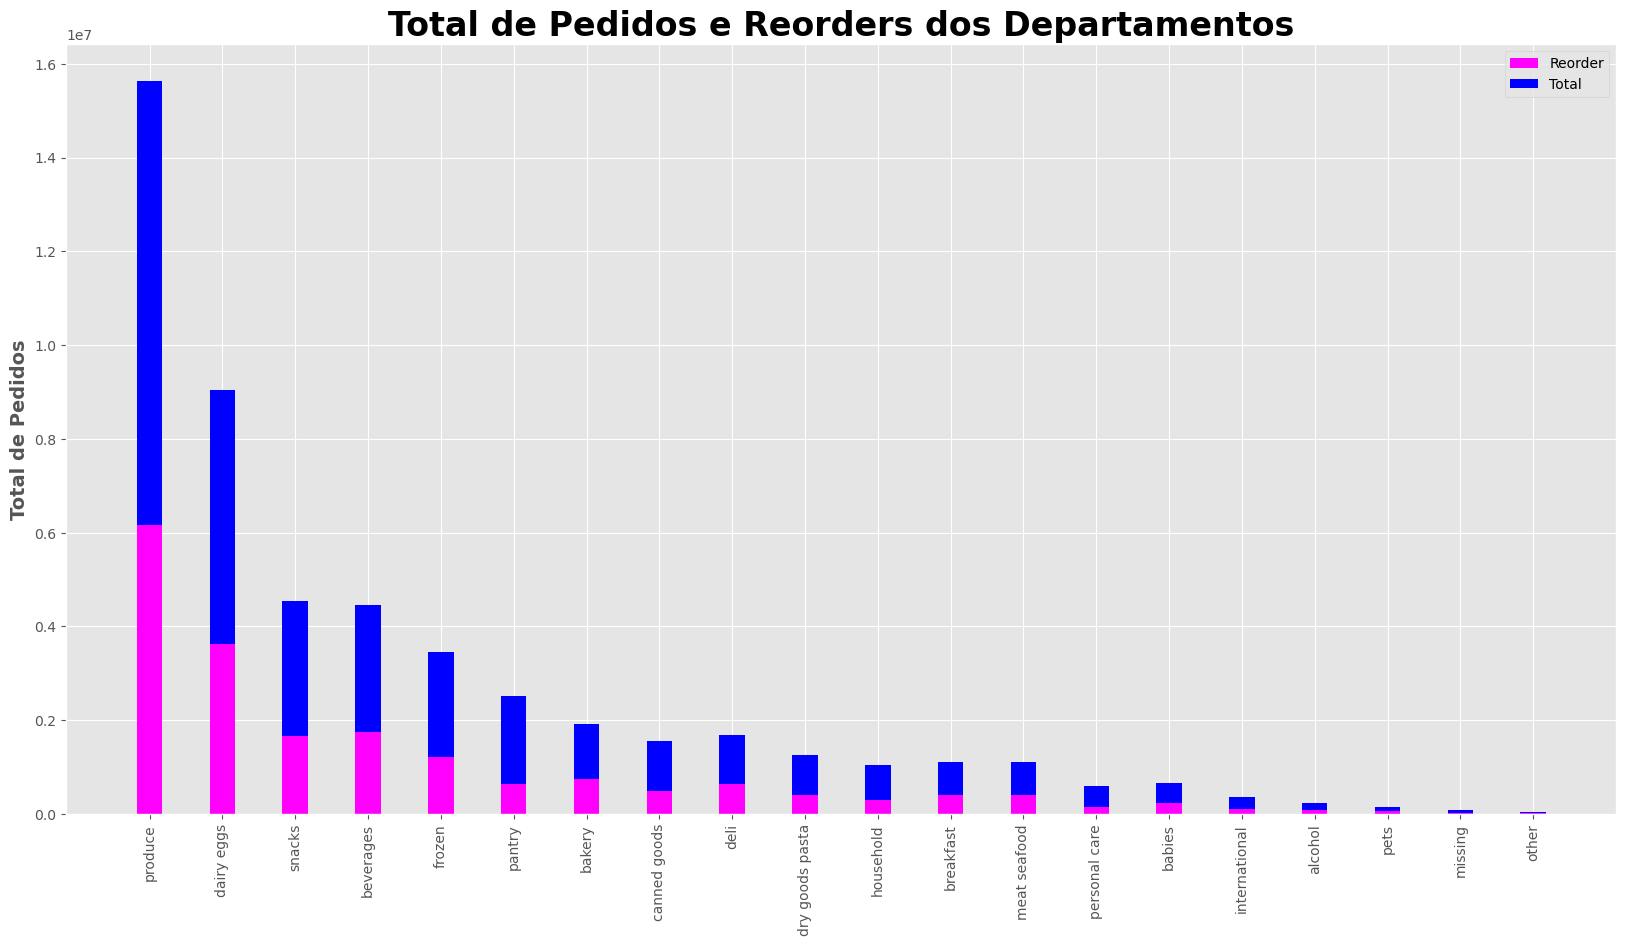

In [51]:
width = 0.35
fig, ax = plt.subplots(figsize = (20, 10))
ax.bar(labels, reorder, width, label = 'Reorder', color = 'magenta')
ax.bar(labels, total, width, bottom = reorder, label = 'Total', color = 'blue')
ax.set_ylabel('Total de Pedidos', fontsize = 14, fontweight = 'bold')
ax.legend()
ax.set_title('Total de Pedidos e Reorders dos Departamentos',fontsize = 24, fontweight = 'bold')
plt.xticks(rotation = 90)
plt.show()

##### 9 - Análise de Reorder por Corredor

In [52]:
grouped_df = order_products_prior.groupby('aisle')['reordered'].agg('mean').reset_index()
grouped_df.head(3)

,aisle,reordered
0,air fresheners candles,0.309052
1,asian foods,0.351132
2,baby accessories,0.550980


In [53]:
list(grouped_df['aisle'])[0:20]

['air fresheners candles',
 'asian foods',
 'baby accessories',
 'baby bath body care',
 'baby food formula',
 'bakery desserts',
 'baking ingredients',
 'baking supplies decor',
 'beauty',
 'beers coolers',
 'body lotions soap',
 'bread',
 'breakfast bakery',
 'breakfast bars pastries',
 'bulk dried fruits vegetables',
 'bulk grains rice dried goods',
 'buns rolls',
 'butter',
 'candy chocolate',
 'canned fruit applesauce']

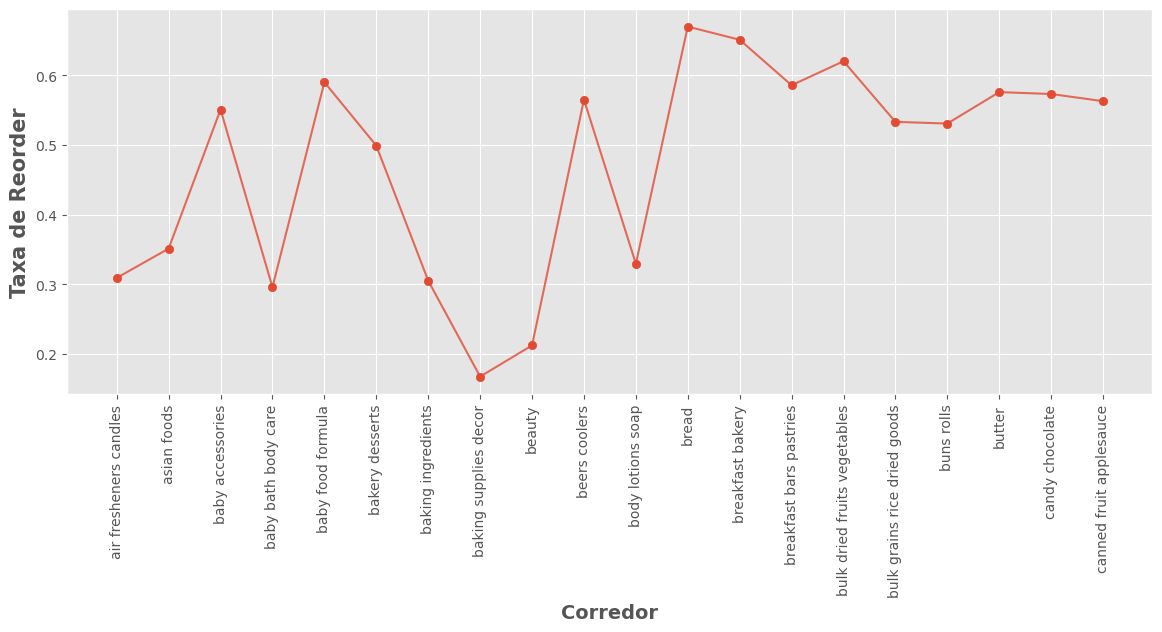

In [54]:
fig = plt.figure(figsize = (14, 5))
plt.plot(list(grouped_df['aisle'])[0:20],grouped_df['reordered'].values[0:20], alpha=0.8)
plt.scatter(list(grouped_df['aisle'])[0:20],grouped_df['reordered'].values[0:20])
plt.xticks(rotation = 90)
plt.xlabel('Corredor', fontsize = 14, fontweight = 'bold')
plt.ylabel('Taxa de Reorder', fontsize = 15, fontweight = 'bold')
plt.show()

##### 10 - Análise de Reorder por Corredor (Total)

In [55]:
%%time
temp_df = order_products_prior.groupby('aisle')['reordered'].agg(['count', 'sum']).rename(
    columns = {'count': 'total', 'sum': 'reorders'})
temp_df = temp_df.sort_values('total', ascending = False).reset_index()

Wall time: 2.58 s


In [56]:
labels = list(temp_df['aisle'][0:20])
reorder = list(temp_df['reorders'][0:20])
total = list(temp_df['total'][0:20])

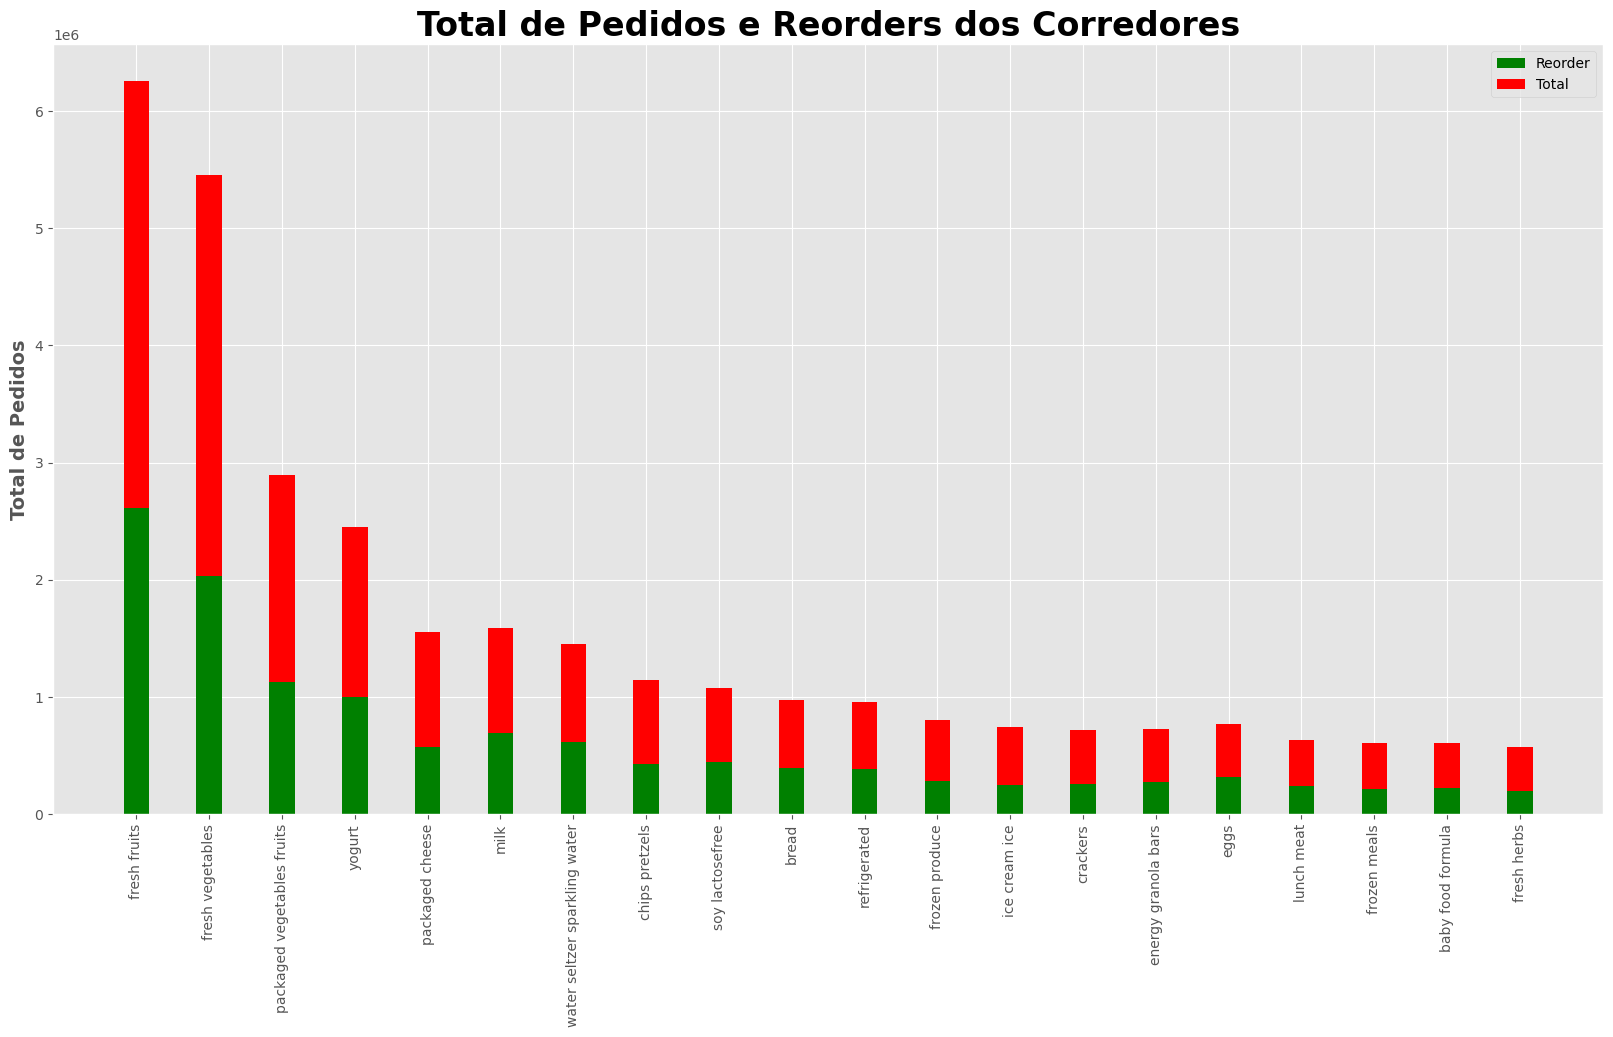

In [57]:
width = 0.35
fig, ax = plt.subplots(figsize = (20, 10))
ax.bar(labels, reorder, width, label = 'Reorder', color = 'green')
ax.bar(labels, total, width, bottom = reorder, label = 'Total', color = 'red')
ax.set_ylabel('Total de Pedidos', fontsize = 14, fontweight = 'bold')
ax.legend()
ax.set_title('Total de Pedidos e Reorders dos Corredores',fontsize = 24, fontweight = 'bold')
plt.xticks(rotation = 90)
plt.show()

#### 10 - Executa o Algoritimo Apriori com Support = 0.01 e Confidence = 0.2

In [58]:
transactions_tup = [tuple(row) for row in transactions['Products'].tolist()]

In [59]:
st = datetime.now()
itemsets_ap, rules_ap, = apriori(transactions_tup[:500000], min_support = 0.005, min_confidence = 0.2)
print('Tempo de Execução: ', datetime.now() - st)

Tempo de Execução:  0:00:07.144519


In [60]:
rules_ap

[{4605} -> {24852},
 {4920} -> {24852},
 {5876} -> {13176},
 {5876} -> {47209},
 {8277} -> {13176},
 {8277} -> {24852},
 {9076} -> {24852},
 {19057} -> {13176},
 {21137} -> {13176},
 {21903} -> {13176},
 {22935} -> {13176},
 {27966} -> {13176},
 {30391} -> {13176},
 {37646} -> {13176},
 {39275} -> {13176},
 {45007} -> {13176},
 {47209} -> {13176},
 {16797} -> {24852},
 {21137} -> {24852},
 {27966} -> {21137},
 {30391} -> {21137},
 {39275} -> {21137},
 {21903} -> {24852},
 {24964} -> {22935},
 {26209} -> {24852},
 {27845} -> {24852},
 {28204} -> {24852},
 {30489} -> {24852},
 {37646} -> {24852},
 {40706} -> {24852},
 {42265} -> {24852},
 {44632} -> {24852},
 {45066} -> {24852},
 {47626} -> {24852},
 {47766} -> {24852},
 {49683} -> {24852},
 {31717} -> {26209},
 {30391} -> {47209}]

In [61]:
item_A = [27966, 47209, 21137, 47766]
item_B = [13176, 13176, 24852, 24852]
temp = pd.DataFrame()
temp['itemA'] = item_A
temp['itemB'] = item_B

In [62]:
support_A = []
support_B = []
support_AB = []
confidence_AB = []
lift_AB = []

In [63]:
for i in range(len(temp)):
    
    #Calcula o support de A
    support_A.append(itemsets_ap[1][tuple([temp['itemA'][i],])] / 500000)
    
    #Calcula o support de B
    support_B.append(itemsets_ap[1][tuple([temp['itemB'][i],])] / 500000)
    
    #Calcula o support de A e B
    if tuple([temp['itemA'][i], temp['itemB'][i]]) in itemsets_ap[2].keys():
        support_AB.append(itemsets_ap[2][tuple([temp['itemA'][i],temp['itemB'][i]])] / 500000)
    else:
        support_AB.append(itemsets_ap[2][tuple([temp['itemB'][i],temp['itemA'][i]])] / 500000)
        
    #Calcula a confidence
    confidence_AB.append(support_AB[i] / support_A[i])
    
    #alcula o lift
    lift_AB.append(support_AB[i] / (support_A[i] * support_B[i]))

In [64]:
df_rules_ap = pd.DataFrame()
df_rules_ap['product_id'] = item_A
df_rules_ap = df_rules_ap.merge(products, on = 'product_id', how = 'left')
df_rules_ap['product_A'] = df_rules_ap['product_name']
df_rules_ap = df_rules_ap.drop(columns = ['product_id', 'product_name', 'aisle_id','department_id'], 
                               axis = 1)
df_rules_ap['product_id'] = item_B
df_rules_ap = df_rules_ap.merge(products, on = 'product_id', how = 'left')
df_rules_ap['product_B'] = df_rules_ap['product_name']
df_rules_ap = df_rules_ap.drop(columns = ['product_id', 'product_name', 'aisle_id','department_id'], 
                               axis = 1)
df_rules_ap['Support_A'] = support_A
df_rules_ap['Support_B'] = support_B
df_rules_ap['Support_AB'] = support_AB
df_rules_ap['Confidence_AB'] = confidence_AB
df_rules_ap['Lift_AB'] = lift_AB

In [65]:
df_rules_ap.sort_values(by = 'Confidence_AB', ascending = False)

,product_A,product_B,Support_A,Support_B,Support_AB,Confidence_AB,Lift_AB
3,Organic Avocado,Banana,0.054564,0.147194,0.016328,0.299245,2.032997
0,Organic Raspberries,Bag of Organic Bananas,0.042334,0.117802,0.012428,0.293570,2.492064
1,Organic Hass Avocado,Bag of Organic Bananas,0.066218,0.117802,0.019260,0.290857,2.469037
2,Organic Strawberries,Banana,0.082550,0.147194,0.017596,0.213156,1.448127


In [66]:
df_rules_ap.sort_values(by = 'Lift_AB', ascending = False)

,product_A,product_B,Support_A,Support_B,Support_AB,Confidence_AB,Lift_AB
0,Organic Raspberries,Bag of Organic Bananas,0.042334,0.117802,0.012428,0.293570,2.492064
1,Organic Hass Avocado,Bag of Organic Bananas,0.066218,0.117802,0.019260,0.290857,2.469037
3,Organic Avocado,Banana,0.054564,0.147194,0.016328,0.299245,2.032997
2,Organic Strawberries,Banana,0.082550,0.147194,0.017596,0.213156,1.448127
